In [1]:
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Dense,Activation,Dropout,Flatten,ZeroPadding2D
from tensorflow.keras.models import Sequential,Model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [2]:
input_shape = (224, 224, 3)
img_width=224
img_height=224
batch_size=10
epocs=20

In [3]:
# !pip install split-folders

Splitting data into test, train and validation datasets

In [4]:
# import splitfolders 
# input_folder = './tumor_dataset/dataset'
# output_folder = './tumor_dataset/data'
# splitfolders.ratio(input_folder,output=output_folder,
#                   seed=42,ratio=(0.7,0.2,0.1),
#                   group_prefix=None)

In [5]:
train_data_dir="./tumor_dataset/data/train"
validation_data_dir="./tumor_dataset/data/val"
test_data_dir="./tumor_dataset/data/test"

creating dataset generator and augmentation function

In [7]:
validation_datagen=ImageDataGenerator(
    rescale=1./255
)

train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.3,
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.2
)

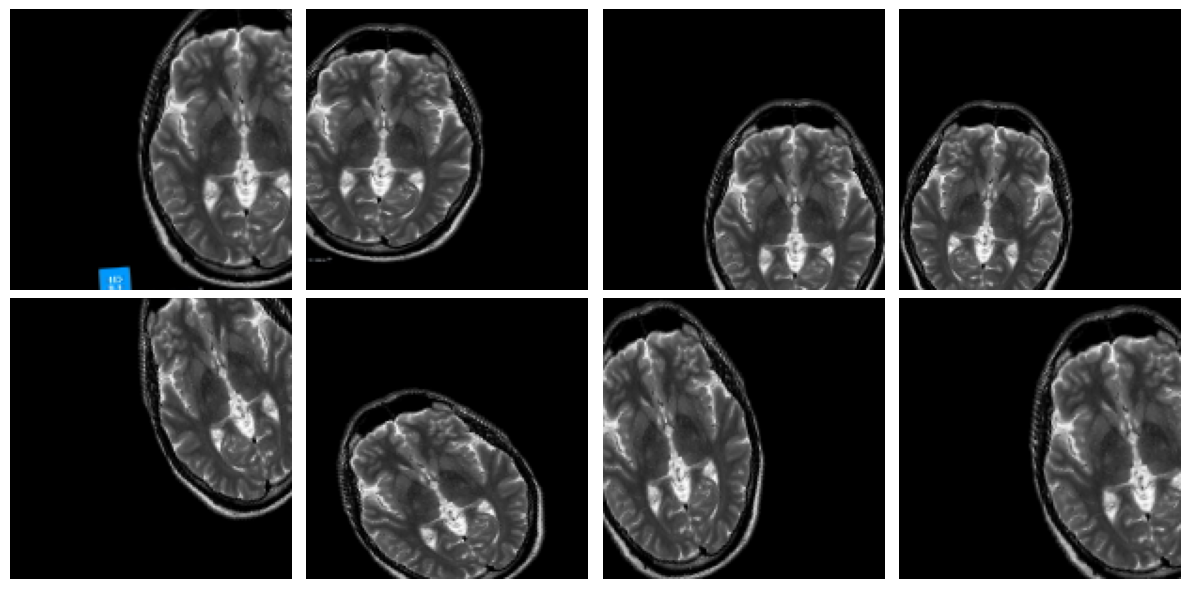

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load a sample image from the training set
img_path = './tumor_dataset/data/test/yes/no.jpg'  # Replace 'path_to_your_image.jpg' with the actual path to your image
img = image.load_img(img_path, target_size=(150, 150))  # Assuming the target size is (150, 150) for example

# Convert the image to an array
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

# Generate augmented images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    for batch in train_datagen.flow(x, batch_size=1):
        ax.imshow(image.array_to_img(batch[0]))
        ax.axis('off')
        break

plt.tight_layout()
plt.show()

In [7]:
#preprocessing the data using train and validation data generator 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode ='categorical',
        shuffle = True)

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

test_generator = validation_datagen.flow_from_directory(
        test_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True)

Found 2100 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 305 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import VGG19



# Re-loads the VGG model without the top or FC layers
VGG19 = VGG19(weights = 'imagenet',
                 include_top = False,
                 input_shape = (224, 224, 3))

# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in VGG19.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(VGG19.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 Conv2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 Conv2D False
20 Conv2D False
21 MaxPooling2D False


In [9]:
from tensorflow.keras.layers import GlobalMaxPool2D
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
def addTopVGG(hp):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""
    top_model = VGG19.output
    topmodel= BatchNormalization()(top_model)
    top_model = GlobalMaxPool2D()(top_model)
    top_model = Dense(units=hp.Int('dense_1_units', min_value=32, max_value=1024, step=16),
                activation='relu')(top_model)
    top_model = Dense(units=hp.Int('dense_2_units', min_value=32, max_value=1024, step=16),
                activation='relu')(top_model)
    top_model = Dense(units=hp.Int('dense_3_units', min_value=32, max_value=512, step=16),
                activation='relu')(top_model)
    top_model = Dense(2,activation='softmax')(top_model)
    model = Model(inputs=VGG19.input, outputs=top_model)
    model.compile(loss = 'categorical_crossentropy',
        optimizer = RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3,1e-4])),
        metrics = ['accuracy'])
    return model

In [10]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
tuner_search=RandomSearch(addTopVGG,
                          objective='val_accuracy',
                          max_trials=20,directory='output',project_name="VGG Tumor")

C:\Users\Kashyap Ghimire\AppData\Local\Temp\ipykernel_2304\2047034677.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [11]:
tuner_search.search(train_generator,epochs=5,validation_data=validation_generator)

Trial 20 Complete [00h 02m 24s]
val_accuracy: 0.8533333539962769

Best val_accuracy So Far: 0.8983333110809326
Total elapsed time: 00h 47m 57s


In [12]:
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# initiate RMSprop optimizer and configure some parameters
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


checkpoint = ModelCheckpoint("VGG_tuned.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_loss', #value being monitored for improvement
                          min_delta = 0.001,  #Abs value and is the main change required before we stop
                          patience = 5, #no of epocs we wait before stopping
                          verbose = 1,
                          restore_best_weights = True) #keep the best weigts once stopped

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.001,
                              patience = 5,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

In [14]:
# model.compile(loss = 'categorical_crossentropy',
#         optimizer = RMSprop(lr = 0.0001),
#         metrics = ['accuracy'])

In [15]:
train = model.fit_generator(
    train_generator,
    steps_per_epoch =2100 // batch_size,
    epochs = 200,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = 600 // batch_size,
    initial_epoch=5)

C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 6/200
210/210 [==============================] - 30s 138ms/step - loss: 0.3508 - accuracy: 0.8452 - val_loss: 0.2599 - val_accuracy: 0.8767

Epoch 00006: val_loss improved from inf to 0.25995, saving model to VGG_tuned.h5
Epoch 7/200
210/210 [==============================] - 29s 136ms/step - loss: 0.3264 - accuracy: 0.8519 - val_loss: 0.2536 - val_accuracy: 0.8850

Epoch 00007: val_loss improved from 0.25995 to 0.25358, saving model to VGG_tuned.h5
Epoch 8/200
210/210 [==============================] - 28s 135ms/step - loss: 0.3504 - accuracy: 0.8433 - val_loss: 0.2515 - val_accuracy: 0.8867

Epoch 00008: val_loss improved from 0.25358 to 0.25153, saving model to VGG_tuned.h5
Epoch 9/200
210/210 [==============================] - 28s 135ms/step - loss: 0.3229 - accuracy: 0.8571 - val_loss: 0.2133 - val_accuracy: 0.9100

Epoch 00009: val_loss improved from 0.25153 to 0.21330, saving model to VGG_tuned.h5
Epoch 10/200
210/210 [==============================] - 29s 137ms/step - los

C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[161 139]
 [163 137]]
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       300
           1       0.50      0.46      0.48       300

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.50       600



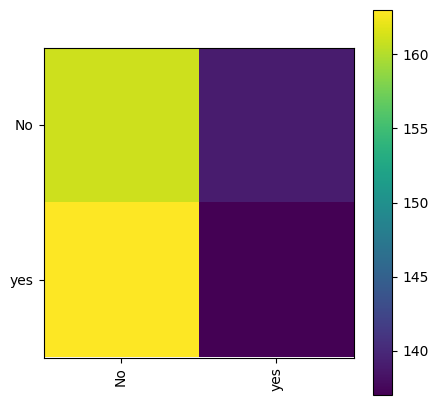

In [24]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model

img_row, img_height, img_depth = 227,224,3


class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

nb_train_samples = 2100
nb_validation_samples = 600

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(5,5))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print(cnf_matrix)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

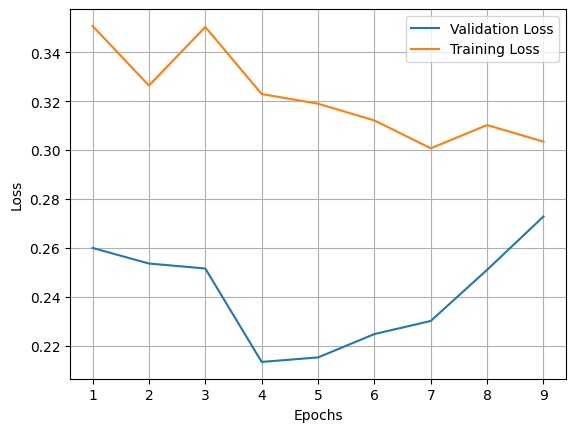

In [25]:
# Plotting our loss charts
import matplotlib.pyplot as plt
epochs=34
history_dict = train.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

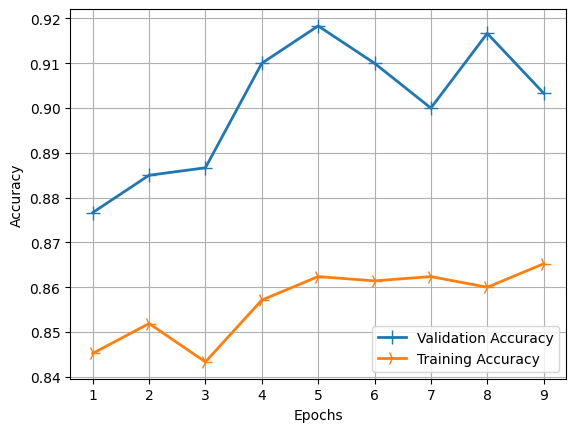

In [26]:
# Plotting our accuracy charts
import matplotlib.pyplot as plt

history_dict = train.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

(1, 224, 224, 3)
[[0. 1.]]
The category =  Tumor


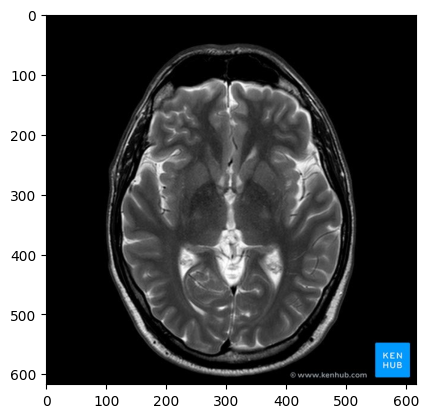

In [27]:
#testing the model on datas from test dataset

import numpy as np
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras import models
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img

d = {0:'No tumor',1:'Tumor'}
input_shape = (224, 224, 3)
image_path = './tumor_dataset/data/test/yes/no.jpg'
model = models.load_model('VGG_tuned.h5')
test_image = load_img(image_path,target_size = input_shape)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis = 0)
print(test_image.shape)
result = model.predict(test_image)
print(result)

testImage = img.imread(image_path)
print("The category = ",d[np.argmax(result)])
# displaying the modified image
plt.imshow(testImage)

In [20]:
test_dir='./tumor_dataset/data/test'
test_gen=validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode='categorical'
)
#predicting the datasets class and value loss(Testing accuracy and loss)
model.evaluate_generator(test_gen,steps=3)


Found 305 images belonging to 2 classes.


C:\annaconda\envs\tf\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.22312766313552856, 0.8833333253860474]

Accuracy: 0.7383333333333333


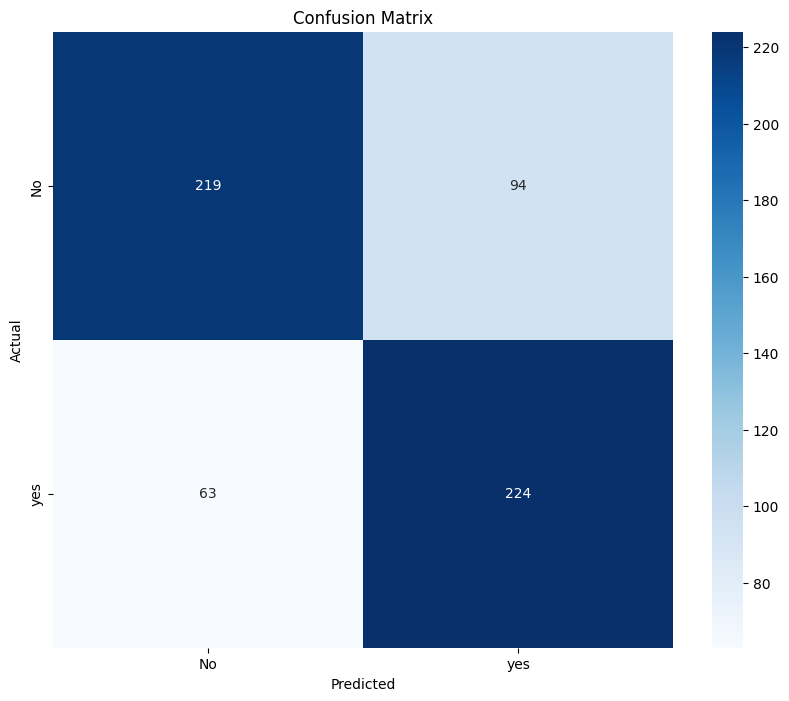

In [40]:
import numpy as np
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import os
from sklearn.metrics import classification_report, confusion_matrix

# Load pre-trained model
model = load_model('newVGG.h5')

# Function to extract features using a pre-trained CNN
def extract_features(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Assuming input size of the model is 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()

# Example directory containing images for classification
data_dir = './tumor_dataset/dataset'
classes = os.listdir(data_dir)

# Extract features for all images in the dataset
X = []
y = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        features = extract_features(model, img_path)
        X.append(features)
        y.append(class_name)

X = np.array(X)
y = np.array(y)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVC classifier
svc = SVC(kernel='poly')
svc.fit(X_train, y_train)

# Predict on test set
y_pred = svc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.78      0.70      0.74       313
         yes       0.70      0.78      0.74       287

    accuracy                           0.74       600
   macro avg       0.74      0.74      0.74       600
weighted avg       0.74      0.74      0.74       600



In [37]:
import joblib

# Save the trained SVC model
joblib.dump(svc, 'svm_vgg.pkl')

['svm_vgg.pkl']

In [38]:

model=joblib.load('svm_model.pkl')

In [33]:
def predict_class(model, svc, img_path):
    features = extract_features(model, img_path)
    predicted_class = svc.predict([features])
    return predicted_class[0]